In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
BATCH_SIZE = 256
NUM_TRAIN = 50000
NUM_VAL = 10000
IMG_C = train_x.shape[-3]
IMG_H = train_x.shape[-2]
IMG_W = train_x.shape[-1]

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1000)

In [58]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)
        self.fc_var = nn.Linear(128 * 3 * 3, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1)),
            nn.Flatten()
        )
        self.fc_probs = nn.Linear(31 * 31, IMG_H * IMG_W)

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.decode(x)
        probs = torch.sigmoid(self.fc_probs(x))
        return probs

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z, mu_z, log_var_z = self.encoder(x)
        probs_x = self.decoder(z)
        return mu_z, log_var_z, probs_x

    def reconstruct(self, probs_x):
        bern_dist = torch.distributions.Bernoulli(probs_x)
        x_recon = bern_dist.sample()
        return x_recon.view(x_recon.shape[0], IMG_C, IMG_H, IMG_W)

In [59]:
LATENT_DIM = 10

encoder = Encoder(input_dim=IMG_C, latent_dim=LATENT_DIM)
decoder = Decoder(latent_dim=LATENT_DIM, output_dim=IMG_C)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=1152, out_features=10, bias=True)
    (fc_var): Linear(in_features=1152, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(10, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentu

  5%|▌         | 1/20 [00:05<01:49,  5.76s/it]

Epoch 1, Mean Training ELBO 195.779309921875, Mean Validation ELBO 160.4981405517578


 10%|█         | 2/20 [00:11<01:43,  5.73s/it]

Epoch 2, Mean Training ELBO 136.0055608203125, Mean Validation ELBO 127.22591630859375


 15%|█▌        | 3/20 [00:17<01:37,  5.73s/it]

Epoch 3, Mean Training ELBO 120.33989013671875, Mean Validation ELBO 117.80248123779297


 20%|██        | 4/20 [00:23<01:32,  5.79s/it]

Epoch 4, Mean Training ELBO 113.43113615234375, Mean Validation ELBO 112.22858776855469


 25%|██▌       | 5/20 [00:28<01:26,  5.78s/it]

Epoch 5, Mean Training ELBO 110.58755275390625, Mean Validation ELBO 111.27072810058594


 30%|███       | 6/20 [00:34<01:20,  5.77s/it]

Epoch 6, Mean Training ELBO 108.58473060546875, Mean Validation ELBO 108.6168837890625


 35%|███▌      | 7/20 [00:40<01:14,  5.76s/it]

Epoch 7, Mean Training ELBO 107.36131220703125, Mean Validation ELBO 109.02338186035156


 40%|████      | 8/20 [00:46<01:09,  5.76s/it]

Epoch 8, Mean Training ELBO 106.2797716796875, Mean Validation ELBO 107.04126518554688


 45%|████▌     | 9/20 [00:51<01:03,  5.79s/it]

Epoch 9, Mean Training ELBO 105.507747734375, Mean Validation ELBO 106.58674233398438


 50%|█████     | 10/20 [00:57<00:57,  5.79s/it]

Epoch 10, Mean Training ELBO 104.58890236328125, Mean Validation ELBO 105.53749658203125


 55%|█████▌    | 11/20 [01:03<00:52,  5.79s/it]

Epoch 11, Mean Training ELBO 104.13269375, Mean Validation ELBO 105.198497265625


 60%|██████    | 12/20 [01:09<00:46,  5.79s/it]

Epoch 12, Mean Training ELBO 103.53243384765625, Mean Validation ELBO 106.86417537841797


 65%|██████▌   | 13/20 [01:15<00:40,  5.80s/it]

Epoch 13, Mean Training ELBO 103.24510537109374, Mean Validation ELBO 105.77015642089843


 70%|███████   | 14/20 [01:21<00:34,  5.83s/it]

Epoch 14, Mean Training ELBO 102.6394495703125, Mean Validation ELBO 104.4216806274414


 75%|███████▌  | 15/20 [01:26<00:29,  5.83s/it]

Epoch 15, Mean Training ELBO 102.25660802734374, Mean Validation ELBO 104.04238972167968


 80%|████████  | 16/20 [01:32<00:23,  5.83s/it]

Epoch 16, Mean Training ELBO 101.9143219140625, Mean Validation ELBO 104.79197506103516


 85%|████████▌ | 17/20 [01:38<00:17,  5.83s/it]

Epoch 17, Mean Training ELBO 101.65826853515625, Mean Validation ELBO 103.45809649658203


 90%|█████████ | 18/20 [01:44<00:11,  5.82s/it]

Epoch 18, Mean Training ELBO 101.43699421875, Mean Validation ELBO 103.19041088867188


 95%|█████████▌| 19/20 [01:50<00:05,  5.84s/it]

Epoch 19, Mean Training ELBO 101.11659381835938, Mean Validation ELBO 103.22125311279297


100%|██████████| 20/20 [01:56<00:00,  5.80s/it]

Epoch 20, Mean Training ELBO 100.99951872070312, Mean Validation ELBO 103.2115341430664


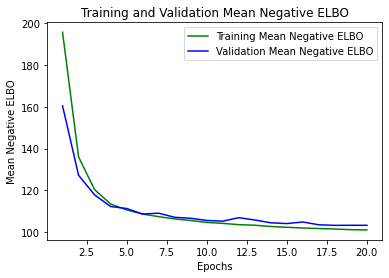

In [60]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(num_epochs, patience=5):
    train_elbos = []
    val_elbos = []
    best_val_elbo = np.inf
    tolerance = 0
    epochs = num_epochs
    for epoch in tqdm(range(num_epochs)):
        overall_train_elbo = 0.0
        overall_val_elbo = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            x, _ = batch
            x = x.to(DEVICE)
            mu_z, log_var_z, probs_x = vae(x)
            x = torch.flatten(x, start_dim=1)
            log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
            kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
            negative_elbo = -log_p + kl
            negative_elbo.backward()
            optimizer.step()
            overall_train_elbo += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                mu_z, log_var_z, probs_x = vae(x)
                x = torch.flatten(x, start_dim=1)
                log_p = -F.binary_cross_entropy(probs_x, x, reduction='sum')
                kl = -0.5 * torch.sum(1 + log_var_z - mu_z.pow(2) - log_var_z.exp())
                negative_elbo = -log_p + kl
                overall_val_elbo += negative_elbo.item()
        mean_train_elbo = overall_train_elbo / NUM_TRAIN
        mean_val_elbo = overall_val_elbo / NUM_VAL
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, mean_train_elbo, mean_val_elbo))
        train_elbos.append(mean_train_elbo)
        val_elbos.append(mean_val_elbo)
        if mean_val_elbo < best_val_elbo:
            best_val_elbo = mean_val_elbo
            tolerance = 0
        else:
            tolerance += 1
            if tolerance == patience:
                print('Early Stopped!')
                epochs = epoch + 1
                break
    plt.plot(range(1, epochs + 1), train_elbos, 'g', label='Training Mean Negative ELBO')
    plt.plot(range(1, epochs + 1), val_elbos, 'b', label='Validation Mean Negative ELBO')
    plt.title('Training and Validation Mean Negative ELBO')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Negative ELBO')
    plt.legend()
    plt.show()
train_vae(num_epochs=20)

In [61]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        _, _, probs_x = vae(x)
        # x_recon = vae.reconstruct(probs_x)
        x_recon = probs_x
        return x, x_recon
test_batch, test_batch_recon = test_vae()

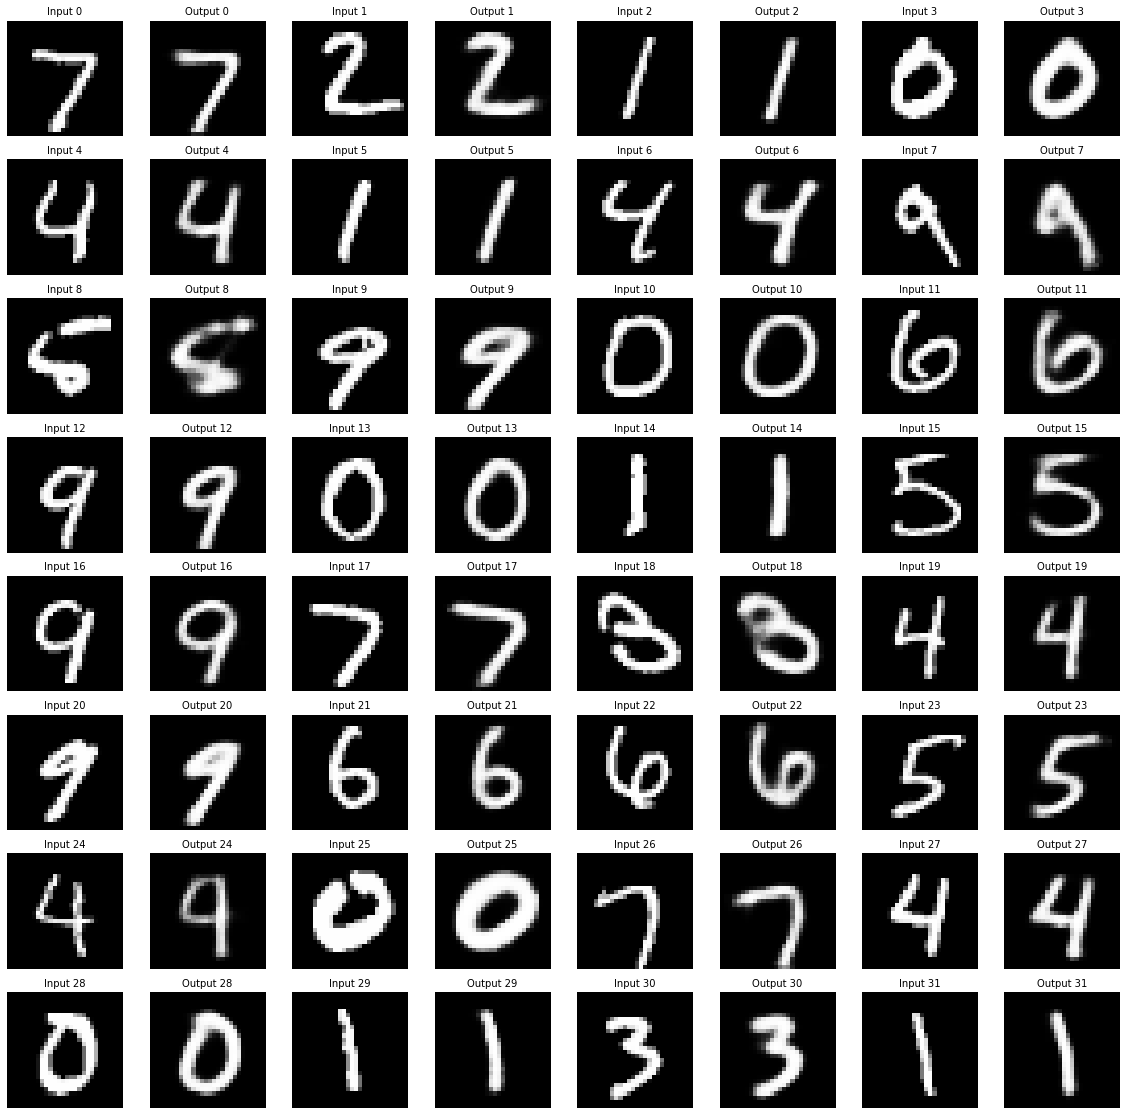

In [62]:
def show_images(x, x_recon):
    """ plots first 32 images and reconstructions"""
    x = x.view(x.shape[0], 28, 28)
    x_recon = x_recon.view(x_recon.shape[0], 28, 28)
    fig, ax = plt.subplots(8, 8, figsize=(20, 20))
    for i in range(8):
        for j in range(4):
            ax[i][2*j].imshow(x[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j+1].imshow(x_recon[i*4+j].cpu().numpy(), cmap="Greys_r")
            ax[i][2*j].set_title(f"Input {i*4+j}", fontsize=10)
            ax[i][2*j+1].set_title(f"Output {i*4+j}", fontsize=10)
            ax[i][2*j].axis('off')
            ax[i][2*j+1].axis('off')
show_images(test_batch, test_batch_recon)

(1000, 10)
(1000, 2)


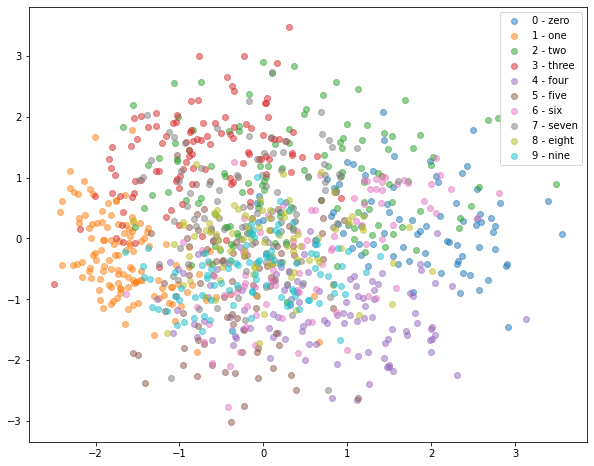

In [64]:
def plot_latent_space_pca(path='latent_10d.png', labels=None):
    x, y = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        mu_z, _, _ = vae(x)
        plt.figure(figsize=(10, 8))
        targets = y.data.cpu().numpy()
        latent = mu_z.data.cpu().numpy()
        pca = PCA(n_components=2)
        latent = pca.fit_transform(latent)
        for i in np.unique(targets):
            inds = np.where(targets==i)[0]
            plt.scatter(latent[inds, 0], latent[inds, 1], alpha=0.5)
        plt.legend(labels, fontsize=10)
        plt.savefig(path)
        plt.show()
plot_latent_space_pca(labels=test_metadata.classes)

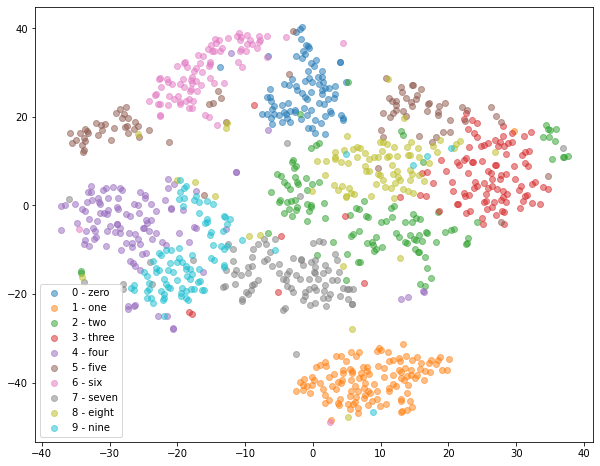

In [66]:
def plot_latent_space_tsne(path='latent_16d.png', labels=None):
    x, y = next(iter(test_dataloader))
    x = x.to(DEVICE)
    with torch.no_grad():
        mu_z, _, _ = vae(x)
        plt.figure(figsize=(10, 8))
        targets = y.data.cpu().numpy()
        latent = mu_z.data.cpu().numpy()
        tsne = TSNE(n_components=2)
        latent = tsne.fit_transform(latent)
        for i in np.unique(targets):
            inds = np.where(targets==i)[0]
            plt.scatter(latent[inds, 0], latent[inds, 1], alpha=0.5)
        plt.legend(labels, fontsize=10)
        plt.savefig(path)
        plt.show()
plot_latent_space_tsne(labels=test_metadata.classes)